In [1]:
import sys
import time
import warnings

import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from collections import Counter

from IPython.display import HTML

#sys.path.append("code/.")

#import mglearn
from IPython.display import display
#from plotting_functions import *

# Classifiers and regressors
from sklearn.dummy import DummyClassifier, DummyRegressor

# Preprocessing and pipeline
from sklearn.impute import SimpleImputer

# train test split and cross validation
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    LabelEncoder,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from xgboost import XGBClassifier

#from utils import *

pd.set_option("display.max_colwidth", 200)

from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority')

In [2]:
dap_33clust = pd.read_csv("DAP_seq_33clusters_scRNAseq_combined_24March2023.csv", index_col = 0)
cols_to_drop = []
counts_1=[]
for i in range(602,len(dap_33clust.columns)):
    y=dap_33clust[dap_33clust.columns[i]]
    counter=Counter(y)
    if(counter[1]<100):
        cols_to_drop.append(dap_33clust.columns[i])
    else:
        counts_1.append(counter[1])

In [3]:
dap_33clust.drop(cols_to_drop, axis=1, inplace=True)
dap_33clust.iloc[1:5, 568:5670]

,1,2,3,4,5,6,7,8,9,10,...,GO:0061630,GO:0071456,GO:0071555,GO:0071704,GO:0090305,GO:0090502,GO:0098869,GO:0099503,GO:0106310,GO:0110165
Gene ID,,,,,,,,,,,,,,,,,,,,,
AT1G01020,0.825579,0.410447,0.261396,0.152758,0.163924,0.272320,0.258516,0.457860,0.321913,0.371860,...,0,0,0,0,0,0,0,0,0,0
AT1G01030,0.001090,0.003155,0.015176,0.000867,0.275636,0.115203,0.008890,0.002562,0.055250,0.003478,...,0,0,0,0,0,0,0,0,0,0
AT1G01040,0.022025,0.023524,0.100888,0.008440,0.090527,0.108768,0.104148,0.046074,0.076399,0.018313,...,0,0,0,0,1,1,0,0,0,0
AT1G01050,0.958800,1.651358,2.126612,1.235073,1.609432,0.692831,3.054592,0.215002,0.714507,5.115776,...,0,0,0,0,0,0,0,0,0,0


In [4]:
DAP_columns = list(range(568))
Cluster_columns = list(range(568,602))
GO_columns = list(range(602,829))
Root33_data_setA, Root33_data_setB = train_test_split(dap_33clust, test_size = 0.5, random_state = 42)
# variable_genes = pd.read_csv('ATH_6000_variable_gens_14Feb2023.csv', index_col = 0)

In [5]:
# Create a dictionary of machine learning models to test
models = {
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'MLP': MLPClassifier(),
    'LDA': LinearDiscriminantAnalysis(),
    'Adaboost': AdaBoostClassifier(),
}

In [6]:
def cross_validation(model, _X, _y, _cv=5):
      '''Function to perform 5 Folds Cross-Validation
       Parameters
       ----------
      model: Python Class, default=None
              This is the machine learning algorithm to be used for training.
      _X: array
           This is the matrix of features.
      _y: array
           This is the target variable.
      _cv: int, default=5
          Determines the number of folds for cross-validation.
       Returns
       -------
       The function returns a dictionary containing the metrics 'accuracy', 'precision',
       'recall', 'f1' for both training set and validation set.
      '''
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)

      # Adjust predictions using the new threshold
      y_pred = (results['test_precision'] > 0.7).astype(int)
      y_true = _y
      
      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Std Validation Accuracy":results['test_accuracy'].std()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              
              }
    
def plot_result(x_label, y_label, plot_title, train_data, val_data):
        '''Function to plot a grouped bar chart showing the training and validation
          results of the ML model in each fold after applying K-fold cross-validation.
         Parameters
         ----------
         x_label: str, 
            Name of the algorithm used for training e.g 'Decision Tree'
          
         y_label: str, 
            Name of metric being visualized e.g 'Accuracy'
         plot_title: str, 
            This is the title of the plot e.g 'Accuracy Plot'
         
         train_result: list, array
            This is the list containing either training precision, accuracy, or f1 score.
        
         val_result: list, array
            This is the list containing either validation precision, accuracy, or f1 score.
         Returns
         -------
         The function returns a Grouped Barchart showing the training and validation result
         in each fold.
        '''
        
        # Set size of plot
        plt.figure(figsize=(12,6))
        labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold","6th Fold", "7th Fold", "8th Fold", "9th Fold", "10th Fold"]
        X_axis = np.arange(len(labels))
        ax = plt.gca()
        plt.ylim(0.40000, 1)
        plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
        plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
        plt.title(plot_title, fontsize=30)
        plt.xticks(X_axis, labels)
        plt.xlabel(x_label, fontsize=14)
        plt.ylabel(y_label, fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()
    
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)
    
# Create the column transformer to apply the transformers to specific columns
preprocessor = ColumnTransformer(
    transformers=[
        ('skip_568', 'passthrough', slice(0, 568)),  # skip columns 1-500
        ('minmax_scaler', MinMaxScaler(), slice(568, 602)),  # apply min-max scaling to columns 501-553
        ('skip_46', 'passthrough', slice(602, 829)),  # skip columns 554-600
    ]
)

pipe = Pipeline([
        ('preprocessor', preprocessor),
        #('undersample', RandomUnderSampler(sampling_strategy="majority")),   
        ('model', RandomForestClassifier(max_depth = 10, n_estimators=20)),
    ])

Feature_columns = DAP_columns + Cluster_columns 
Prediction_columns = GO_columns
len(Feature_columns), len(Feature_columns + Prediction_columns)

(602, 829)

In [7]:
go_names = Root33_data_setA.iloc[:,len(Feature_columns) :].columns
feature_names = Root33_data_setA.iloc[:, :len(Feature_columns)-1 ].columns
Root33_data_setA.iloc[3:5, 600:605]

,33,GO:0000139,GO:0000166,GO:0000287,GO:0000325
Gene ID,,,,,
AT4G13263,0.0,0,0,0,0
AT2G17770,0.0,0,0,0,0


In [8]:
Root33_data_setA.shape[1]

829

## Train

In [9]:
warnings.filterwarnings("ignore")

Root33_Go_Mean_Accuracy=[]
Root33_Go_Std_Accuracy=[]
Root33_Go_10cross_Accuracies=[]
Random_forest_result_pred_list = []
Root33_results_dict = {}
column_headers = list(Root33_data_setA.columns)

X=Root33_data_setA.iloc[:, :len(Feature_columns) ]

for i in range(len(Feature_columns), Root33_data_setA.shape[1]):
    y=Root33_data_setA.iloc[:,i]
    
    # X_sample, y_sample = undersample.fit_resample(X, y)
    X_sample = X
    y_sample = y
    goterm = column_headers[i]
    Root33_results_dict[goterm] = cross_validation(pipe,X_sample, y_sample, 10)

KeyboardInterrupt: 

In [10]:
len(Feature_columns)

602

In [44]:
pd.DataFrame(Root33_results_dict).T.head()

,Training Accuracy scores,Mean Training Accuracy,Training Precision scores,Mean Training Precision,Training Recall scores,Mean Training Recall,Training F1 scores,Mean Training F1 Score,Validation Accuracy scores,Mean Validation Accuracy,Std Validation Accuracy,Validation Precision scores,Mean Validation Precision,Validation Recall scores,Mean Validation Recall,Validation F1 scores,Mean Validation F1 Score
GO:0000166,"[0.911616786214857, 0.913018385687196, 0.9119465743259956, 0.9139253029928271, 0.9106274218814412, 0.911616786214857, 0.9103800807980872, 0.9122011541632317, 0.910717230008244, 0.912366034624897]",91.184158,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",1.0,"[0.06944444444444445, 0.08499566348655681, 0.07372072853425846, 0.09453599306157849, 0.0598438855160451, 0.07025151777970512, 0.05724197745013009, 0.07632263660017347, 0.060711188204683436, 0.0780...",0.072513,"[0.12987012987012989, 0.1566746602717826, 0.13731825525040386, 0.17274167987321712, 0.11292962356792145, 0.1312803889789303, 0.10828547990155865, 0.14182111200644643, 0.11447260834014719, 0.144810...",0.13502,"[0.9043026706231454, 0.9050445103857567, 0.9050445103857567, 0.9050445103857567, 0.9050445103857567, 0.9050445103857567, 0.9050445103857567, 0.9049740163325909, 0.9042316258351893, 0.9049740163325...",90.487494,0.030553,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.0
GO:0000287,"[0.996702118888614, 0.9962074367219061, 0.9963723307774754, 0.9961249896941216, 0.9963723307774754, 0.9960425426663368, 0.9962898837496909, 0.9965375103050289, 0.9958779884583677, 0.9966199505358615]",99.631471,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",1.0,"[0.4444444444444444, 0.3611111111111111, 0.3888888888888889, 0.3472222222222222, 0.3888888888888889, 0.3333333333333333, 0.375, 0.4166666666666667, 0.3055555555555556, 0.4305555555555556]",0.379167,"[0.6153846153846153, 0.5306122448979591, 0.56, 0.5154639175257731, 0.56, 0.5, 0.5454545454545454, 0.5882352941176471, 0.46808510638297873, 0.6019417475728156]",0.548518,"[0.9940652818991098, 0.9940652818991098, 0.9940652818991098, 0.9940652818991098, 0.9940652818991098, 0.9940652818991098, 0.9940652818991098, 0.994060876020787, 0.994060876020787, 0.994060876020787]",99.406396,0.000202,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.0
GO:0000325,"[0.9803776073872537, 0.9807073954983923, 0.9794706900816226, 0.980542501442823, 0.9812020776651001, 0.9806249484706077, 0.981696759831808, 0.9807914262159934, 0.9806265457543281, 0.9804616652926628]",98.065016,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",1.0,"[0.2347266881028939, 0.24758842443729903, 0.1967741935483871, 0.23870967741935484, 0.2645161290322581, 0.24193548387096775, 0.2838709677419355, 0.2508038585209003, 0.24437299035369775, 0.237942122...",0.244124,"[0.3802083333333333, 0.39690721649484534, 0.3288409703504043, 0.38541666666666663, 0.4183673469387755, 0.38961038961038963, 0.4422110552763819, 0.40102827763496146, 0.39276485788113696, 0.38441558...",0.391977,"[0.9747774480712166, 0.9747774480712166, 0.9747774480712166, 0.9747774480712166, 0.9740356083086054, 0.973293768545994, 0.973293768545994, 0.9762435040831478, 0.9732739420935412, 0.9747587230883444]",97.440091,0.089137,"[0.0, 0.5, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",0.35,"[0.0, 0.029411764705882353, 0.02857142857142857, 0.02857142857142857, 0.0, 0.0, 0.0, 0.058823529411764705, 0.0, 0.0]",0.014538,"[0.0, 0.05555555555555555, 0.05555555555555556, 0.05555555555555556, 0.0, 0.0, 0.0, 0.1111111111111111, 0.0, 0.0]",0.027778
GO:0000398,"[0.9957127545551983, 0.9958776486107676, 0.9956303075274137, 0.9960425426663368, 0.995795201582983, 0.9956303075274137, 0.9957127545551983, 0.9957131079967024, 0.9956306677658697, 0.9949711459192085]",99.567164,"[1.0, 1

In [45]:
Root33_results_df = pd.DataFrame(Root33_results_dict).T
Root33_results_df.columns

Index(['Training Accuracy scores', 'Mean Training Accuracy',
       'Training Precision scores', 'Mean Training Precision',
       'Training Recall scores', 'Mean Training Recall', 'Training F1 scores',
       'Mean Training F1 Score', 'Validation Accuracy scores',
       'Mean Validation Accuracy', 'Std Validation Accuracy',
       'Validation Precision scores', 'Mean Validation Precision',
       'Validation Recall scores', 'Mean Validation Recall',
       'Validation F1 scores', 'Mean Validation F1 Score'],
      dtype='object')

In [46]:
results_to_keep = ['Mean Training Accuracy', 'Mean Training F1 Score', 'Mean Validation Accuracy', 'Std Validation Accuracy','Mean Validation Precision', 'Mean Validation Recall','Mean Validation F1 Score']

In [47]:
Root33_results_df[results_to_keep].to_csv("12Dec2023_DAPSeq_Root33_results_df.csv")

In [48]:
Root33_results_df["Mean Training F1 Score"].head()

GO:0000166     0.13502
GO:0000287    0.548518
GO:0000325    0.391977
GO:0000398    0.456468
GO:0000976    0.446527
Name: Mean Training F1 Score, dtype: object

In [49]:
selected_gos_list = Root33_results_df.loc[Root33_results_df['Mean Validation Accuracy'] >= 75].index.tolist()

In [50]:
selected_gos_list

['GO:0000166',
 'GO:0000287',
 'GO:0000325',
 'GO:0000398',
 'GO:0000976',
 'GO:0000978',
 'GO:0000981',
 'GO:0003674',
 'GO:0003676',
 'GO:0003677',
 'GO:0003682',
 'GO:0003690',
 'GO:0003700',
 'GO:0003723',
 'GO:0003729',
 'GO:0003735',
 'GO:0003743',
 'GO:0003779',
 'GO:0003824',
 'GO:0003924',
 'GO:0004252',
 'GO:0004386',
 'GO:0004497',
 'GO:0004518',
 'GO:0004519',
 'GO:0004553',
 'GO:0004601',
 'GO:0004672',
 'GO:0004674',
 'GO:0004712',
 'GO:0004721',
 'GO:0004722',
 'GO:0004842',
 'GO:0004857',
 'GO:0005506',
 'GO:0005507',
 'GO:0005509',
 'GO:0005515',
 'GO:0005516',
 'GO:0005524',
 'GO:0005525',
 'GO:0005575',
 'GO:0005576',
 'GO:0005615',
 'GO:0005634',
 'GO:0005654',
 'GO:0005681',
 'GO:0005694',
 'GO:0005730',
 'GO:0005737',
 'GO:0005739',
 'GO:0005743',
 'GO:0005759',
 'GO:0005768',
 'GO:0005773',
 'GO:0005774',
 'GO:0005777',
 'GO:0005783',
 'GO:0005789',
 'GO:0005794',
 'GO:0005802',
 'GO:0005829',
 'GO:0005840',
 'GO:0005856',
 'GO:0005874',
 'GO:0005886',
 'GO:00058

In [18]:
# Training on set A and testing to setB
warnings.filterwarnings("ignore")

Root33_pred_Mean_Accuracy=[]
Root33_pred_Std_Accuracy=[]
Root33_pred_10cross_Accuracies=[]
Random_forest_result_pred_list2 = []
Root33_results_dict3 = {}
predictions_dict_Root33 = {}
column_headers = list(Root33_data_setA.columns)

pipe2 = Pipeline(
    steps=[
        ("scaler", MinMaxScaler()),
        ("classifier", RandomForestClassifier(max_depth = 10, n_estimators=20)),
    ]
)
X=Root33_data_setA.iloc[:, :len(Feature_columns)-1 ]
Xb=Root33_data_setB.iloc[:, :len(Feature_columns)-1 ]
new_threshold = 0.7
for i in selected_gos_list:
    y=Root33_data_setA[i]
    X_sample, y_sample = undersample.fit_resample(X, y)
    #goterm = column_headers[i]
    yb=Root33_data_setB[i]
    X_test, y_test = (Xb, yb)
    #goterm.append(column_headers[i])
    
    #Random_forest_result = cross_validation(pipe,X_sample, y_sample, 5)
    #Root33_pred_Mean_Accuracy.append(Random_forest_result["Mean Validation Accuracy"])
    #Root33_pred_Std_Accuracy.append(Random_forest_result["Std Validation Accuracy"])
    #Root33_pred_10cross_Accuracies.append(Random_forest_result["Validation Accuracy scores"])
    #Random_forest_result_pred = cross_val_predict(pipe, X_sample, y_sample, cv=5, method='predict_proba')
    #Random_forest_result_pred_list2.append(Random_forest_result_pred)
    pipe2.fit(X_sample, y_sample)
    Root33_results_dict3[i] = pipe2.predict(X_test)
    predictor = pipe2.fit(X_sample, y_sample)
    predictions_dict_Root33[i] = (predictor.predict_proba(X_test)[:,1] > new_threshold).astype(int)

predictions_dict_Root33

{'GO:0003735': array([1, 0, 0, ..., 0, 0, 0]),
 'GO:0005840': array([0, 0, 0, ..., 0, 0, 0]),
 'GO:0006260': array([0, 0, 0, ..., 0, 0, 0]),
 'GO:0006412': array([1, 0, 0, ..., 0, 0, 0]),
 'GO:0022625': array([1, 0, 0, ..., 0, 0, 0]),
 'GO:0022626': array([0, 0, 0, ..., 0, 0, 0]),
 'GO:0031640': array([0, 0, 0, ..., 0, 1, 1]),
 'GO:0042254': array([0, 0, 0, ..., 0, 0, 0])}

In [19]:
genes = Root33_data_setB.index.tolist()
 
novel_predictions_df = pd.DataFrame(Root33_results_dict3, index = genes)
novel_predictions_thresh = pd.DataFrame(predictions_dict_Root33, index = genes)

novel_predictions_df

,GO:0003735,GO:0005840,GO:0006260,GO:0006412,GO:0022625,GO:0022626,GO:0031640,GO:0042254
AT1G65220,1,1,0,1,1,1,0,0
AT3G59690,1,0,0,0,0,0,0,1
AT4G25830,0,0,0,0,0,0,0,0
AT3G58960,0,0,0,0,0,0,1,0
AT2G05590,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...
AT5G23380,0,0,0,0,0,0,0,0
AT5G09900,1,1,0,0,1,1,0,1
AT4G10000,0,0,1,0,0,0,0,0
AT3G05975,0,0,0,0,0,0,1,0


In [20]:
dap_33clust

,AT3G12130_colamp_a_AT3G12130,AT5G63260_col_a_AT5G63260,CDM1_colamp_a_AT1G68200,At5g08750_col_a_AT5G08750,AT5G63260_colamp_a_AT5G63260,FRS9_col_a_AT4G38170,FRS9_colamp_a_AT4G38170,HAT2_col_v31_AT5G47370,AT4G00250_col_a_AT4G00250,ARF2_col_v31_AT5G62000,...,GO:0061630,GO:0071456,GO:0071555,GO:0071704,GO:0090305,GO:0090502,GO:0098869,GO:0099503,GO:0106310,GO:0110165
Gene ID,,,,,,,,,,,,,,,,,,,,,
AT1G01010,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AT1G01020,0,0,0,0,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
AT1G01030,0,1,0,0,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
AT1G01040,1,1,0,0,0,0,0,1,0,1,...,0,0,0,0,1,1,0,0,0,0
AT1G01050,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AT5G67600,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AT5G67610,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
AT5G67620,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
Root33_with_ind = dap_33clust
Root33_with_ind.head()

,AT3G12130_colamp_a_AT3G12130,AT5G63260_col_a_AT5G63260,CDM1_colamp_a_AT1G68200,At5g08750_col_a_AT5G08750,AT5G63260_colamp_a_AT5G63260,FRS9_col_a_AT4G38170,FRS9_colamp_a_AT4G38170,HAT2_col_v31_AT5G47370,AT4G00250_col_a_AT4G00250,ARF2_col_v31_AT5G62000,...,GO:0061630,GO:0071456,GO:0071555,GO:0071704,GO:0090305,GO:0090502,GO:0098869,GO:0099503,GO:0106310,GO:0110165
Gene ID,,,,,,,,,,,,,,,,,,,,,
AT1G01010,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AT1G01020,0,0,0,0,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
AT1G01030,0,1,0,0,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
AT1G01040,1,1,0,0,0,0,0,1,0,1,...,0,0,0,0,1,1,0,0,0,0
AT1G01050,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
orig_predictions_df2 = Root33_with_ind.loc[novel_predictions_df.index, selected_gos_list]

def compare_cells(x, y):
    if x == 0 and y == 0:
        return '0'
    elif x == 1 and y == 1:
        return '1'
    elif x == 0 and y == 1:
        return "+"
    elif x == 1 and y == 0:
        return "-"
    else:
        raise ValueError("Invalid cell values: x={}, y={}".format(x, y))

#result = orig_predictions_df3.apply(lambda x: x.apply(lambda y: compare_cells(y, novel_predictions_df.loc[x.name, y])), axis=0)
result = orig_predictions_df2.apply(lambda x: x.combine(novel_predictions_df[x.name], compare_cells))
result2 = orig_predictions_df2.apply(lambda x: x.combine(novel_predictions_thresh[x.name], compare_cells))
result.head()

,GO:0003735,GO:0005840,GO:0006260,GO:0006412,GO:0022625,GO:0022626,GO:0031640,GO:0042254
AT1G65220,+,+,0,+,+,+,0,0
AT3G59690,+,0,0,0,0,0,0,+
AT4G25830,0,0,0,0,0,0,0,0
AT3G58960,0,0,0,0,0,0,+,0
AT2G05590,0,0,0,+,0,0,0,0


In [30]:
FP =  result.apply(lambda x: x.value_counts().get('+', 0))
TP =  result.apply(lambda x: x.value_counts().get('1', 0))
FN =  result.apply(lambda x: x.value_counts().get('-', 0))
TN =  result.apply(lambda x: x.value_counts().get('0', 0))
FP2 =  result2.apply(lambda x: x.value_counts().get('+', 0))
TP2 =  result2.apply(lambda x: x.value_counts().get('1', 0))
FN2 =  result2.apply(lambda x: x.value_counts().get('-', 0))
TN2 =  result2.apply(lambda x: x.value_counts().get('0', 0))
 
summary_table = pd.concat([TP, FP, TN, FN], axis=1)
summary_table.columns = ["TP", "FP", "TN", "FN"]
summary_table

,TP,FP,TN,FN
GO:0003735,149,1139,12148,42
GO:0005802,113,4189,9153,23
GO:0005840,164,1629,11637,48
GO:0006412,196,2531,10693,58
GO:0009451,51,3910,9504,13
GO:0022625,57,1509,11902,10
GO:0022626,76,1552,11827,23
GO:0031640,114,3302,10043,19
GO:0042254,29,2897,10532,20


In [31]:
summary_table2 = pd.concat([TP2, FP2, TN2, FN2], axis=1)
summary_table2.columns = ["TP", "FP", "TN", "FN"]
summary_table2

,TP,FP,TN,FN
GO:0003735,114,283,13004,77
GO:0005802,66,1468,11874,70
GO:0005840,122,264,13002,90
GO:0006412,139,628,12596,115
GO:0009451,24,642,12772,40
GO:0022625,46,333,13078,21
GO:0022626,58,243,13136,41
GO:0031640,86,1686,11659,47
GO:0042254,17,1296,12133,32


In [32]:
eval_metrics = pd.DataFrame()
eval_metrics2 = pd.DataFrame()
eval_metrics2["precision_score"] = summary_table2["TP"]/(summary_table2["TP"] + summary_table2["FP"])
eval_metrics["precision_score"] = summary_table["TP"]/(summary_table["TP"] + summary_table["FP"])
eval_metrics

,precision_score
GO:0003735,0.115683
GO:0005802,0.026267
GO:0005840,0.091467
GO:0006412,0.071874
GO:0009451,0.012876
GO:0022625,0.036398
GO:0022626,0.046683
GO:0031640,0.033372
GO:0042254,0.009911


In [33]:
eval_metrics["Train Precision"] = Root33_results_df.loc[eval_metrics.index]["Mean Training Precision"]
eval_metrics["Validation Precision"] = Root33_results_df.loc[eval_metrics.index]["Mean Validation Precision"]
eval_metrics["recall_score"] =  summary_table["TP"]/(summary_table["TP"] + summary_table["FN"])
eval_metrics["Training Recall"] = Root33_results_df.loc[eval_metrics.index]["Mean Training Recall"]
eval_metrics["Validation Recall"] = Root33_results_df.loc[eval_metrics.index]["Mean Validation Recall"]
eval_metrics["F1_score"] = 2 * (eval_metrics["precision_score"] * eval_metrics["recall_score"] )/ (eval_metrics["precision_score"] + eval_metrics["recall_score"])
eval_metrics["Training F1"] = Root33_results_df.loc[eval_metrics.index]["Mean Training F1 Score"]
eval_metrics["Validation F1"] = Root33_results_df.loc[eval_metrics.index]["Mean Validation F1 Score"]
eval_metrics["Accuracy"] = (summary_table["TP"] + summary_table["TN"]) /(summary_table["TP"] + summary_table["TN"] + summary_table["FP"] + summary_table["FN"])
eval_metrics["Train Accuracy"] = Root33_results_df.loc[eval_metrics.index]["Mean Training Accuracy"]
eval_metrics["Validation Accuracy"] = Root33_results_df.loc[eval_metrics.index]["Mean Validation Accuracy"]
eval_metrics.sort_values(by="Validation Precision", ascending = False)
eval_metrics.sort_values(by="Validation Precision", ascending = False)[["precision_score", "recall_score", "F1_score", "Accuracy"]]

,precision_score,recall_score,F1_score,Accuracy
GO:0022625,0.036398,0.850746,0.069810,0.887298
GO:0003735,0.115683,0.780105,0.201487,0.912376
GO:0005840,0.091467,0.773585,0.163591,0.875575
GO:0022626,0.046683,0.767677,0.088014,0.883143
GO:0042254,0.009911,0.591837,0.019496,0.783573
GO:0031640,0.033372,0.857143,0.064243,0.753598
GO:0006412,0.071874,0.771654,0.131499,0.807909
GO:0009451,0.012876,0.796875,0.025342,0.708933
GO:0005802,0.026267,0.830882,0.050924,0.687491


In [34]:
eval_metrics2["Train Precision"] = Root33_results_df.loc[eval_metrics2.index]["Mean Training Precision"]
eval_metrics2["Validation Precision"] = Root33_results_df.loc[eval_metrics2.index]["Mean Validation Precision"]
eval_metrics2["recall_score"] =  summary_table2["TP"]/(summary_table2["TP"] + summary_table2["FN"])
eval_metrics2["Training Recall"] = Root33_results_df.loc[eval_metrics2.index]["Mean Training Recall"]
eval_metrics2["Validation Recall"] = Root33_results_df.loc[eval_metrics2.index]["Mean Validation Recall"]
eval_metrics2["F1_score"] = 2 * (eval_metrics2["precision_score"] * eval_metrics2["recall_score"] )/ (eval_metrics2["precision_score"] + eval_metrics2["recall_score"])
eval_metrics2["Training F1"] = Root33_results_df.loc[eval_metrics2.index]["Mean Training F1 Score"]
eval_metrics2["Validation F1"] = Root33_results_df.loc[eval_metrics2.index]["Mean Validation F1 Score"]
eval_metrics2["Accuracy"] = (summary_table["TP"] + summary_table2["TN"]) /(summary_table2["TP"] + summary_table2["TN"] + summary_table2["FP"] + summary_table2["FN"])
eval_metrics2["Train Accuracy"] = Root33_results_df.loc[eval_metrics2.index]["Mean Training Accuracy"]
eval_metrics2["Validation Accuracy"] = Root33_results_df.loc[eval_metrics.index]["Mean Validation Accuracy"]
eval_metrics2.sort_values(by="Validation Precision", ascending = False)[["precision_score", "recall_score", "F1_score", "Accuracy"]]

,precision_score,recall_score,F1_score,Accuracy
GO:0022625,0.121372,0.686567,0.206278,0.974551
GO:0003735,0.287154,0.596859,0.387755,0.975887
GO:0005840,0.316062,0.575472,0.408027,0.976851
GO:0022626,0.192691,0.585859,0.290000,0.980264
GO:0042254,0.012947,0.346939,0.024963,0.902359
GO:0031640,0.048533,0.646617,0.090289,0.873498
GO:0006412,0.181226,0.547244,0.272282,0.949102
GO:0009451,0.036036,0.375000,0.065753,0.951402
GO:0005802,0.043025,0.485294,0.079042,0.889375


# False Positives and False Negative Genes for each GO Term

In [27]:
# SONG:
# Need a table for each GO term, what are the genes that are FP / FN 
# FN genes can be used to understand why the ML failed on these genes
# FP genes are useful predictions that were not annotated by prior research but can be “novel” predictions by the ML method and 
# can potentially be validated, say via AlphaFold type of ML method followed by bench work. 

result_dict = {}
for go_term in result.columns:
    fp_genes = []
    fn_genes = []
    for index, value in result[go_term].items():
        gene = index  
        if value == '+':
            fp_genes.append(gene)
        elif value == '-':
            fn_genes.append(gene)

    result_dict[go_term] = {'FP': fp_genes, 'FN': fn_genes}

# To access the FP genes for each GO term, use result_dict['go_term']['FP' / 'FN']
result_dict['GO:0003735']['FN']

['AT4G37660',
 'AT5G59240',
 'AT4G21460',
 'AT2G47570',
 'AT3G17626',
 'AT5G63070',
 'AT5G14290',
 'AT1G12960',
 'AT1G66580',
 'AT5G24510',
 'AT3G27840',
 'AT3G09680',
 'AT2G34210',
 'AT1G52370',
 'AT3G15190',
 'AT5G51610',
 'AT5G15650',
 'AT3G52300',
 'AT1G79850',
 'AT3G44890',
 'AT2G03130',
 'AT1G77750',
 'AT2G43310',
 'AT1G29970',
 'AT1G69485',
 'AT3G04770',
 'AT5G40040',
 'AT1G36240',
 'AT4G17560',
 'AT3G17820',
 'AT3G61111',
 'AT5G63300',
 'AT3G27160',
 'AT3G08520',
 'AT4G09012',
 'AT5G15760',
 'AT3G22450']

# Balanced Sampling

### 0.5 Threshold

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample

CB_Root33_Go_Mean_Accuracy = []
CB_Root33_Go_Std_Accuracy = []
CB_Root33_Go_10cross_Accuracies = []
CB_Root33_Go_10cross_Mean_F1=[]
CB_Root33_Go_10cross_Mean_Precision=[]
CB_Root33_Go_10cross_Mean_Recall=[]
CB_Root33_results_dict = {}
column_headers = list(Root33_data_setA.columns)


for i in range(len(Feature_columns), Root33_data_setA.shape[1]):
    X = Root33_data_setA.iloc[:, :len(Feature_columns) ]
    y = Root33_data_setA.iloc[:,i]

    # Determin the minority class
    minority_class = 1 if sum(y == 1) < sum(y == 0) else 0
    minority_indices = np.where(y == minority_class)[0]
    majority_indices = np.where(y != minority_class)[0]
    majority_indices_downsampled = resample(majority_indices, replace=False, n_samples=len(minority_indices), random_state=0)

    print("For this GO Term, Reduced Majority Size: ", len(majority_indices_downsampled), "Minority Size: ", len(minority_indices))
    
    # Combine minority and downsampled majority indices
    indices_combined = np.concatenate([minority_indices, majority_indices_downsampled])

    # Subset the data based on the selected indices
    X_balanced = X.iloc[indices_combined, :]
    y_balanced = y.iloc[indices_combined]

    # Train the random forest model
    goterm = column_headers[i]
    CB_Root33_results_dict[goterm] = cross_validation(pipe, X_balanced, y_balanced, 10)

    # CB_Root33_Go_Mean_Accuracy.append(Random_forest_result["Mean Validation Accuracy"])
    # CB_Root33_Go_Std_Accuracy.append(Random_forest_result["Std Validation Accuracy"])
    # CB_Root33_Go_10cross_Accuracies.append(Random_forest_result["Validation Accuracy scores"])
    # CB_Root33_Go_10cross_Mean_F1.append(Random_forest_result["Mean Validation F1 Score"])
    # CB_Root33_Go_10cross_Mean_Precision.append(Random_forest_result["Mean Validation Precision"])
    # CB_Root33_Go_10cross_Mean_Recall.append(Random_forest_result["Mean Validation Recall"])

For this GO Term, Reduced Majority Size:  1281 Minority Size:  1281
For this GO Term, Reduced Majority Size:  80 Minority Size:  80
For this GO Term, Reduced Majority Size:  345 Minority Size:  345
For this GO Term, Reduced Majority Size:  83 Minority Size:  83
For this GO Term, Reduced Majority Size:  372 Minority Size:  372
For this GO Term, Reduced Majority Size:  122 Minority Size:  122
For this GO Term, Reduced Majority Size:  140 Minority Size:  140
For this GO Term, Reduced Majority Size:  2244 Minority Size:  2244
For this GO Term, Reduced Majority Size:  344 Minority Size:  344
For this GO Term, Reduced Majority Size:  1066 Minority Size:  1066
For this GO Term, Reduced Majority Size:  63 Minority Size:  63
For this GO Term, Reduced Majority Size:  55 Minority Size:  55
For this GO Term, Reduced Majority Size:  822 Minority Size:  822
For this GO Term, Reduced Majority Size:  539 Minority Size:  539
For this GO Term, Reduced Majority Size:  478 Minority Size:  478
For this GO 

In [11]:
CB_Root33_results_df = pd.DataFrame(CB_Root33_results_dict).T
csv_file_path = '22Jan2024_DAPSeq0.5_Root33_results_df.csv'
CB_Root33_results_df.to_csv(csv_file_path, index_label='GO')
CB_Root33_results_df

,Training Accuracy scores,Mean Training Accuracy,Training Precision scores,Mean Training Precision,Training Recall scores,Mean Training Recall,Training F1 scores,Mean Training F1 Score,Validation Accuracy scores,Mean Validation Accuracy,Std Validation Accuracy,Validation Precision scores,Mean Validation Precision,Validation Recall scores,Mean Validation Recall,Validation F1 scores,Mean Validation F1 Score
GO:0000166,"[0.9509761388286334, 0.9596529284164859, 0.9648742411101474, 0.9570685169124025, 0.9570685169124025, 0.9549002601908065, 0.9522983521248916, 0.9588031222896791, 0.9549002601908065, 0.95836947094536]",95.689118,"[0.9545056867891514, 0.9715302491103203, 0.972663139329806, 0.9647266313932981, 0.9639084507042254, 0.961301671064204, 0.9461077844311377, 0.9640350877192982, 0.9704035874439462, 0.9714540588760036]",0.964064,"[0.9470486111111112, 0.9470945359930616, 0.9566348655680833, 0.9488291413703382, 0.9496964440589766, 0.9479618386816999, 0.9592367736339983, 0.9531656548135299, 0.9384215091066782, 0.9444926279271...",0.949258,"[0.9507625272331154, 0.9591567852437418, 0.964582422387407, 0.9567118495846088, 0.9567496723460026, 0.9545851528384279, 0.9526270456503014, 0.9585695595290012, 0.9541446208112875, 0.9577836411609498]",0.956567,"[0.556420233463035, 0.5603112840466926, 0.62109375, 0.5625, 0.625, 0.54296875, 0.5546875, 0.5625, 0.546875, 0.55859375]",56.909503,2.765536,"[0.556390977443609, 0.556390977443609, 0.6165413533834586, 0.5563380281690141, 0.6194029850746269, 0.5426356589147286, 0.547945205479452, 0.5526315789473685, 0.5441176470588235, 0.5555555555555556]",0.564795,"[0.5736434108527132, 0.578125, 0.640625, 0.6171875, 0.6484375, 0.546875, 0.625, 0.65625, 0.578125, 0.5859375]",0.605021,"[0.564885496183206, 0.5670498084291187, 0.6283524904214559, 0.5851851851851853, 0.633587786259542, 0.5447470817120622, 0.583941605839416, 0.6, 0.5606060606060606, 0.570342205323194]",0.58387
GO:0000287,"[1.0, 1.0, 0.9930555555555556, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",99.930556,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",1.0,"[1.0, 1.0, 0.9861111111111112, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",0.998611,"[1.0, 1.0, 0.993006993006993, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",0.999301,"[0.625, 0.4375, 0.6875, 0.625, 0.4375, 0.6875, 0.5, 0.5625, 0.625, 0.5625]",57.5,8.75,"[0.625, 0.4, 0.6666666666666666, 0.625, 0.42857142857142855, 0.7142857142857143, 0.5, 0.5555555555555556, 0.6666666666666666, 0.5714285714285714]",0.575317,"[0.625, 0.25, 0.75, 0.625, 0.375, 0.625, 0.5, 0.625, 0.5, 0.5]",0.5375,"[0.625, 0.3076923076923077, 0.7058823529411765, 0.625, 0.39999999999999997, 0.6666666666666666, 0.5, 0.5882352941176471, 0.5714285714285715, 0.5333333333333333]",0.552324
GO:0000325,"[0.9871175523349437, 0.9871175523349437, 0.9871175523349437, 0.9855072463768116, 0.9903381642512077, 0.9806763285024155, 0.9919484702093397, 0.9887278582930756, 0.9951690821256038, 0.9903381642512...",98.84058,"[0.9934640522875817, 0.9902597402597403, 0.9934640522875817, 0.990228013029316, 0.9967320261437909, 0.9869706840390879, 0.9903846153846154, 0.9871794871794872, 0.9967741935483871, 0.987220447284345]",0.991268,"[0.9806451612903225, 0.9838709677419355, 0.9806451612903225, 0.9806451612903225, 0.9838709677419355, 0.9742765273311897, 0.9935691318327974, 0.9903536977491961, 0.9935691318327974, 0.9935691318327...",0.985502,"[0.987012987012987, 0.9870550161812298, 0.987012987012987, 0.9854132901134521, 0.9902597402597403, 0.9805825242718447, 0.9919743178170144, 0.9887640449438203, 0.9951690821256038, 0.9903846153846154]",0.988363,"[0.7391304347826086, 0.7101449275362319, 0.7246376811594203, 0.7101449275362319, 0.7971014492753623, 0.6811594202898551, 0.7681159420289855, 0.7246376811594203, 0.6956521739130435, 0.7391304347826...",72.898551,3.243917,"[0.7741935483870968, 0.7142857142857143, 0.75, 0.7027027027027027, 0.7837837837837838, 0.6666666666666666, 0.78125, 0.7419354838709677, 0.7096774193548387, 0.7]",0.73245,"[0.6857142857142857, 0.7142857142857143, 

In [12]:
pd.DataFrame(CB_Root33_results_dict).T

,Training Accuracy scores,Mean Training Accuracy,Training Precision scores,Mean Training Precision,Training Recall scores,Mean Training Recall,Training F1 scores,Mean Training F1 Score,Validation Accuracy scores,Mean Validation Accuracy,Std Validation Accuracy,Validation Precision scores,Mean Validation Precision,Validation Recall scores,Mean Validation Recall,Validation F1 scores,Mean Validation F1 Score
GO:0000166,"[0.9509761388286334, 0.9596529284164859, 0.9648742411101474, 0.9570685169124025, 0.9570685169124025, 0.9549002601908065, 0.9522983521248916, 0.9588031222896791, 0.9549002601908065, 0.95836947094536]",95.689118,"[0.9545056867891514, 0.9715302491103203, 0.972663139329806, 0.9647266313932981, 0.9639084507042254, 0.961301671064204, 0.9461077844311377, 0.9640350877192982, 0.9704035874439462, 0.9714540588760036]",0.964064,"[0.9470486111111112, 0.9470945359930616, 0.9566348655680833, 0.9488291413703382, 0.9496964440589766, 0.9479618386816999, 0.9592367736339983, 0.9531656548135299, 0.9384215091066782, 0.9444926279271...",0.949258,"[0.9507625272331154, 0.9591567852437418, 0.964582422387407, 0.9567118495846088, 0.9567496723460026, 0.9545851528384279, 0.9526270456503014, 0.9585695595290012, 0.9541446208112875, 0.9577836411609498]",0.956567,"[0.556420233463035, 0.5603112840466926, 0.62109375, 0.5625, 0.625, 0.54296875, 0.5546875, 0.5625, 0.546875, 0.55859375]",56.909503,2.765536,"[0.556390977443609, 0.556390977443609, 0.6165413533834586, 0.5563380281690141, 0.6194029850746269, 0.5426356589147286, 0.547945205479452, 0.5526315789473685, 0.5441176470588235, 0.5555555555555556]",0.564795,"[0.5736434108527132, 0.578125, 0.640625, 0.6171875, 0.6484375, 0.546875, 0.625, 0.65625, 0.578125, 0.5859375]",0.605021,"[0.564885496183206, 0.5670498084291187, 0.6283524904214559, 0.5851851851851853, 0.633587786259542, 0.5447470817120622, 0.583941605839416, 0.6, 0.5606060606060606, 0.570342205323194]",0.58387
GO:0000287,"[1.0, 1.0, 0.9930555555555556, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",99.930556,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",1.0,"[1.0, 1.0, 0.9861111111111112, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",0.998611,"[1.0, 1.0, 0.993006993006993, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",0.999301,"[0.625, 0.4375, 0.6875, 0.625, 0.4375, 0.6875, 0.5, 0.5625, 0.625, 0.5625]",57.5,8.75,"[0.625, 0.4, 0.6666666666666666, 0.625, 0.42857142857142855, 0.7142857142857143, 0.5, 0.5555555555555556, 0.6666666666666666, 0.5714285714285714]",0.575317,"[0.625, 0.25, 0.75, 0.625, 0.375, 0.625, 0.5, 0.625, 0.5, 0.5]",0.5375,"[0.625, 0.3076923076923077, 0.7058823529411765, 0.625, 0.39999999999999997, 0.6666666666666666, 0.5, 0.5882352941176471, 0.5714285714285715, 0.5333333333333333]",0.552324
GO:0000325,"[0.9871175523349437, 0.9871175523349437, 0.9871175523349437, 0.9855072463768116, 0.9903381642512077, 0.9806763285024155, 0.9919484702093397, 0.9887278582930756, 0.9951690821256038, 0.9903381642512...",98.84058,"[0.9934640522875817, 0.9902597402597403, 0.9934640522875817, 0.990228013029316, 0.9967320261437909, 0.9869706840390879, 0.9903846153846154, 0.9871794871794872, 0.9967741935483871, 0.987220447284345]",0.991268,"[0.9806451612903225, 0.9838709677419355, 0.9806451612903225, 0.9806451612903225, 0.9838709677419355, 0.9742765273311897, 0.9935691318327974, 0.9903536977491961, 0.9935691318327974, 0.9935691318327...",0.985502,"[0.987012987012987, 0.9870550161812298, 0.987012987012987, 0.9854132901134521, 0.9902597402597403, 0.9805825242718447, 0.9919743178170144, 0.9887640449438203, 0.9951690821256038, 0.9903846153846154]",0.988363,"[0.7391304347826086, 0.7101449275362319, 0.7246376811594203, 0.7101449275362319, 0.7971014492753623, 0.6811594202898551, 0.7681159420289855, 0.7246376811594203, 0.6956521739130435, 0.7391304347826...",72.898551,3.243917,"[0.7741935483870968, 0.7142857142857143, 0.75, 0.7027027027027027, 0.7837837837837838, 0.6666666666666666, 0.78125, 0.7419354838709677, 0.7096774193548387, 0.7]",0.73245,"[0.6857142857142857, 0.7142857142857143, 

[0.6033587573270027,
 0.4785613354653603,
 0.7066824950627767,
 0.6652882205513786,
 0.6925828200897343,
 0.6253301046779308,
 0.6145665726355382,
 0.6065418590171087,
 0.604373225775433,
 0.5732612672382306,
 0.5945088245088244,
 0.5541375291375291,
 0.6496609567078943,
 0.6758428579852842,
 0.6836907587079653,
 0.8377775168216344,
 0.4953535353535353,
 0.5483516483516484,
 0.5567354594384417,
 0.5274276600592389,
 0.5008458208458209,
 0.643545155993432,
 0.669902362744468,
 0.6213095238095238,
 0.6152564102564102,
 0.5451666524934892,
 0.48177489177489174,
 0.5999188801040665,
 0.6277196333110325,
 0.6289910062966504,
 0.5708214729886556,
 0.597069597069597,
 0.49942807544698525,
 0.6275357975357976,
 0.597507604566428,
 0.7033787342688271,
 0.5931110043662637,
 0.601323657395479,
 0.5442555994729907,
 0.6157777389331576,
 0.5849325108960082,
 0.6171811338993876,
 0.6290212166687754,
 0.5237579242223205,
 0.6228325825445152,
 0.6369762641898865,
 0.6786946386946386,
 0.64063162585608

In [56]:
Root33_results_df["Mean Validation F1 Score"].tolist()

[0.0,
 0.0,
 0.02777777777777778,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0008849557522123894,
 0.0,
 0.0,
 0.0,
 0.0,
 0.002352941176470588,
 0.0036363636363636364,
 0.13668989501064974,
 0.5484609448522493,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.011300977392667508,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.010448872357008062,
 0.0,
 0.0,
 0.0,
 0.0,
 0.006475050475545485,
 0.01689895470383275,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.08732698567062279,
 0.0,
 0.06591328534596116,
 0.5117988466084418,
 0.0,
 0.0,
 0.00842170931322864,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.39476502836952354,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.06534962310202466,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.011764705882352941,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0086956521739130

### 0.7 Threshold

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample

# change the threshold in cross_validation function

CB_Root33_Go_Mean_Accuracy = []
CB_Root33_Go_Std_Accuracy = []
CB_Root33_Go_10cross_Accuracies = []
CB_Root33_Go_10cross_Mean_F1=[]
CB_Root33_Go_10cross_Mean_Precision=[]
CB_Root33_Go_10cross_Mean_Recall=[]
CB_Root33_results_dict = {}
column_headers = list(Root33_data_setA.columns)


for i in range(len(Feature_columns), Root33_data_setA.shape[1]):
    X = Root33_data_setA.iloc[:, :len(Feature_columns) ]
    y = Root33_data_setA.iloc[:,i]

    # Determin the minority class
    minority_class = 1 if sum(y == 1) < sum(y == 0) else 0
    minority_indices = np.where(y == minority_class)[0]
    majority_indices = np.where(y != minority_class)[0]
    majority_indices_downsampled = resample(majority_indices, replace=False, n_samples=len(minority_indices), random_state=0)

    print("For this GO Term, Reduced Majority Size: ", len(majority_indices_downsampled), "Minority Size: ", len(minority_indices))
    
    # Combine minority and downsampled majority indices
    indices_combined = np.concatenate([minority_indices, majority_indices_downsampled])

    # Subset the data based on the selected indices
    X_balanced = X.iloc[indices_combined, :]
    y_balanced = y.iloc[indices_combined]

    # Train the random forest model
    goterm = column_headers[i]
    CB_Root33_results_dict[goterm] = cross_validation(pipe, X_balanced, y_balanced, 10)

    # CB_Root33_Go_Mean_Accuracy.append(Random_forest_result["Mean Validation Accuracy"])
    # CB_Root33_Go_Std_Accuracy.append(Random_forest_result["Std Validation Accuracy"])
    # CB_Root33_Go_10cross_Accuracies.append(Random_forest_result["Validation Accuracy scores"])
    # CB_Root33_Go_10cross_Mean_F1.append(Random_forest_result["Mean Validation F1 Score"])
    # CB_Root33_Go_10cross_Mean_Precision.append(Random_forest_result["Mean Validation Precision"])
    # CB_Root33_Go_10cross_Mean_Recall.append(Random_forest_result["Mean Validation Recall"])

For this GO Term, Reduced Majority Size:  1281 Minority Size:  1281
For this GO Term, Reduced Majority Size:  80 Minority Size:  80
For this GO Term, Reduced Majority Size:  345 Minority Size:  345
For this GO Term, Reduced Majority Size:  83 Minority Size:  83
For this GO Term, Reduced Majority Size:  372 Minority Size:  372
For this GO Term, Reduced Majority Size:  122 Minority Size:  122
For this GO Term, Reduced Majority Size:  140 Minority Size:  140
For this GO Term, Reduced Majority Size:  2244 Minority Size:  2244
For this GO Term, Reduced Majority Size:  344 Minority Size:  344
For this GO Term, Reduced Majority Size:  1066 Minority Size:  1066
For this GO Term, Reduced Majority Size:  63 Minority Size:  63
For this GO Term, Reduced Majority Size:  55 Minority Size:  55
For this GO Term, Reduced Majority Size:  822 Minority Size:  822
For this GO Term, Reduced Majority Size:  539 Minority Size:  539
For this GO Term, Reduced Majority Size:  478 Minority Size:  478
For this GO 

/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For this GO Term, Reduced Majority Size:  59 Minority Size:  59
For this GO Term, Reduced Majority Size:  309 Minority Size:  309
For this GO Term, Reduced Majority Size:  85 Minority Size:  85
For this GO Term, Reduced Majority Size:  94 Minority Size:  94
For this GO Term, Reduced Majority Size:  67 Minority Size:  67
For this GO Term, Reduced Majority Size:  91 Minority Size:  91
For this GO Term, Reduced Majority Size:  59 Minority Size:  59
For this GO Term, Reduced Majority Size:  90 Minority Size:  90
For this GO Term, Reduced Majority Size:  154 Minority Size:  154
For this GO Term, Reduced Majority Size:  184 Minority Size:  184
For this GO Term, Reduced Majority Size:  89 Minority Size:  89
For this GO Term, Reduced Majority Size:  53 Minority Size:  53
For this GO Term, Reduced Majority Size:  185 Minority Size:  185
For this GO Term, Reduced Majority Size:  434 Minority Size:  434
For this GO Term, Reduced Majority Size:  1065 Minority Size:  1065
For this GO Term, Reduced 

In [16]:
CB_Root33_results_df_t7 = pd.DataFrame(CB_Root33_results_dict).T
csv_file_path = '28Jan2024_DAPSeq0.7_Root33_results_df.csv'
CB_Root33_results_df_t7.to_csv(csv_file_path, index_label='GO')
CB_Root33_results_df_t7

,Training Accuracy scores,Mean Training Accuracy,Training Precision scores,Mean Training Precision,Training Recall scores,Mean Training Recall,Training F1 scores,Mean Training F1 Score,Validation Accuracy scores,Mean Validation Accuracy,Std Validation Accuracy,Validation Precision scores,Mean Validation Precision,Validation Recall scores,Mean Validation Recall,Validation F1 scores,Mean Validation F1 Score
GO:0000166,"[0.9544468546637744, 0.9592190889370933, 0.9605377276669558, 0.9575021682567216, 0.9631396357328708, 0.9640069384215091, 0.9562012142237641, 0.9449262792714658, 0.9531656548135299, 0.9549002601908...",95.680458,"[0.9596136962247586, 0.9600347523892268, 0.9633507853403142, 0.9799818016378526, 0.9635416666666666, 0.9709507042253521, 0.9503424657534246, 0.9422413793103448, 0.9539530842745438, 0.9645704162976...",0.960858,"[0.9487847222222222, 0.95836947094536, 0.9575021682567216, 0.9340849956634866, 0.9627059843885516, 0.9566348655680833, 0.9627059843885516, 0.9479618386816999, 0.9522983521248916, 0.9444926279271466]",0.952554,"[0.9541684853775645, 0.959201388888889, 0.9604175728577643, 0.9564831261101243, 0.9631236442516269, 0.9637396242900831, 0.9564842740198191, 0.945092952875054, 0.9531249999999999, 0.9544259421560036]",0.956626,"[0.5719844357976653, 0.5875486381322957, 0.58203125, 0.53125, 0.59765625, 0.56640625, 0.5546875, 0.5859375, 0.58203125, 0.578125]",57.376581,1.814778,"[0.5736434108527132, 0.5901639344262295, 0.5704697986577181, 0.5298507462686567, 0.5912408759124088, 0.5555555555555556, 0.5486111111111112, 0.5753424657534246, 0.5724137931034483, 0.5714285714285...",0.567872,"[0.5736434108527132, 0.5625, 0.6640625, 0.5546875, 0.6328125, 0.6640625, 0.6171875, 0.65625, 0.6484375, 0.625]",0.619864,"[0.5736434108527132, 0.576, 0.6137184115523465, 0.5419847328244274, 0.6113207547169812, 0.6049822064056939, 0.5808823529411764, 0.6131386861313868, 0.6080586080586081, 0.5970149253731343]",0.592074
GO:0000287,"[1.0, 1.0, 1.0, 0.9930555555555556, 1.0, 1.0, 1.0, 0.9930555555555556, 0.9930555555555556, 1.0]",99.791667,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",1.0,"[1.0, 1.0, 1.0, 0.9861111111111112, 1.0, 1.0, 1.0, 0.9861111111111112, 0.9861111111111112, 1.0]",0.995833,"[1.0, 1.0, 1.0, 0.993006993006993, 1.0, 1.0, 1.0, 0.993006993006993, 0.993006993006993, 1.0]",0.997902,"[0.625, 0.625, 0.5625, 0.625, 0.4375, 0.625, 0.5, 0.5, 0.6875, 0.5625]",57.5,7.28869,"[0.625, 0.6666666666666666, 0.5555555555555556, 0.625, 0.4444444444444444, 0.6666666666666666, 0.5, 0.5, 0.7142857142857143, 0.5555555555555556]",0.585317,"[0.625, 0.5, 0.625, 0.625, 0.5, 0.5, 0.5, 0.5, 0.625, 0.625]",0.5625,"[0.625, 0.5714285714285715, 0.5882352941176471, 0.625, 0.47058823529411764, 0.5714285714285715, 0.5, 0.5, 0.6666666666666666, 0.5882352941176471]",0.570658
GO:0000325,"[0.9758454106280193, 0.9855072463768116, 0.9838969404186796, 0.9903381642512077, 0.9919484702093397, 0.9790660225442834, 0.9806763285024155, 0.9903381642512077, 0.9838969404186796, 0.9935587761674...",98.550725,"[0.9773462783171522, 0.9839228295819936, 0.987012987012987, 0.9935064935064936, 0.9935275080906149, 0.9869281045751634, 0.9776357827476039, 0.987220447284345, 0.990228013029316, 0.9935691318327974]",0.98709,"[0.9741935483870968, 0.9870967741935484, 0.9806451612903225, 0.9870967741935484, 0.9903225806451613, 0.9710610932475884, 0.9839228295819936, 0.9935691318327974, 0.977491961414791, 0.9935691318327974]",0.983897,"[0.9757673667205171, 0.9855072463768115, 0.9838187702265372, 0.9902912621359222, 0.9919224555735057, 0.978930307941653, 0.9807692307692308, 0.9903846153846154, 0.9838187702265372, 0.9935691318327974]",0.985478,"[0.7391304347826086, 0.6521739130434783, 0.6666666666666666, 0.6666666666666666, 0.7391304347826086, 0.7101449275362319, 0.6666666666666666, 0.7246376811594203, 0.7536231884057971, 0.7681159420289...",70.869565,4.018964,"[0.7575757575757576, 0.6571428571428571, 0.6666666666666666, 0.6666666666666666, 0.7297297297297297, 0.6944444444444444, 0.

In [17]:
CB_Root33_results_df

,Training Accuracy scores,Mean Training Accuracy,Training Precision scores,Mean Training Precision,Training Recall scores,Mean Training Recall,Training F1 scores,Mean Training F1 Score,Validation Accuracy scores,Mean Validation Accuracy,Std Validation Accuracy,Validation Precision scores,Mean Validation Precision,Validation Recall scores,Mean Validation Recall,Validation F1 scores,Mean Validation F1 Score
GO:0000166,"[0.9527114967462039, 0.9683297180043384, 0.9531656548135299, 0.9648742411101474, 0.9627059843885516, 0.9540329575021682, 0.9527320034692107, 0.9570685169124025, 0.9605377276669558, 0.9657415437987...",95.918998,"[0.9554585152838428, 0.9753521126760564, 0.9611650485436893, 0.981149012567325, 0.9717064544650752, 0.9540329575021682, 0.9547038327526133, 0.9598603839441536, 0.9682539682539683, 0.9718804920913884]",0.965356,"[0.9496527777777778, 0.9609713790112749, 0.9444926279271466, 0.9479618386816999, 0.9531656548135299, 0.9540329575021682, 0.9505637467476149, 0.9540329575021682, 0.9522983521248916, 0.9592367736339...",0.952641,"[0.9525468001741403, 0.9681083442551333, 0.952755905511811, 0.9642699602999559, 0.9623467600700526, 0.9540329575021682, 0.9526292916123424, 0.9569377990430623, 0.960209881941408, 0.9655172413793104]",0.958935,"[0.5486381322957199, 0.5680933852140078, 0.6015625, 0.59375, 0.59375, 0.609375, 0.53515625, 0.58203125, 0.546875, 0.59375]",57.729815,2.461647,"[0.5503875968992248, 0.568, 0.5902777777777778, 0.5857142857142857, 0.5895522388059702, 0.6029411764705882, 0.5319148936170213, 0.5695364238410596, 0.5454545454545454, 0.5821917808219178]",0.571597,"[0.5503875968992248, 0.5546875, 0.6640625, 0.640625, 0.6171875, 0.640625, 0.5859375, 0.671875, 0.5625, 0.6640625]",0.615195,"[0.5503875968992248, 0.5612648221343872, 0.6250000000000001, 0.6119402985074627, 0.6030534351145038, 0.6212121212121211, 0.5576208178438662, 0.6164874551971327, 0.5538461538461538, 0.6204379562043...",0.592125
GO:0000287,"[1.0, 0.9861111111111112, 1.0, 1.0, 1.0, 0.9930555555555556, 1.0, 0.9930555555555556, 0.9930555555555556, 1.0]",99.652778,"[1.0, 0.9861111111111112, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",0.998611,"[1.0, 0.9861111111111112, 1.0, 1.0, 1.0, 0.9861111111111112, 1.0, 0.9861111111111112, 0.9861111111111112, 1.0]",0.994444,"[1.0, 0.9861111111111112, 1.0, 1.0, 1.0, 0.993006993006993, 1.0, 0.993006993006993, 0.993006993006993, 1.0]",0.996513,"[0.4375, 0.5625, 0.375, 0.625, 0.4375, 0.625, 0.6875, 0.4375, 0.8125, 0.5625]",55.625,12.945197,"[0.4444444444444444, 0.5714285714285714, 0.25, 0.625, 0.4444444444444444, 0.625, 0.6666666666666666, 0.42857142857142855, 1.0, 0.5714285714285714]",0.562698,"[0.5, 0.5, 0.125, 0.625, 0.5, 0.625, 0.75, 0.375, 0.625, 0.5]",0.5125,"[0.47058823529411764, 0.5333333333333333, 0.16666666666666666, 0.625, 0.47058823529411764, 0.625, 0.7058823529411765, 0.39999999999999997, 0.7692307692307693, 0.5333333333333333]",0.529962
GO:0000325,"[0.9790660225442834, 0.9855072463768116, 0.9774557165861514, 0.9855072463768116, 0.9935587761674718, 0.9855072463768116, 0.9919484702093397, 0.9967793880837359, 0.9871175523349437, 0.9806763285024...",98.63124,"[0.9805825242718447, 0.9870550161812298, 0.9868421052631579, 0.9934426229508196, 0.9872611464968153, 0.9839743589743589, 0.9935483870967742, 0.9967845659163987, 0.9902912621359223, 0.9776357827476...",0.987742,"[0.9774193548387097, 0.9838709677419355, 0.967741935483871, 0.9774193548387097, 1.0, 0.9871382636655949, 0.9903536977491961, 0.9967845659163987, 0.9839228295819936, 0.9839228295819936]",0.984857,"[0.9789983844911146, 0.9854604200323102, 0.9771986970684038, 0.9853658536585366, 0.9935897435897436, 0.985553772070626, 0.9919484702093397, 0.9967845659163987, 0.9870967741935485, 0.9807692307692308]",0.986277,"[0.7246376811594203, 0.6956521739130435, 0.7101449275362319, 0.7101449275362319, 0.7681159420289855, 0.6956521739130435, 0.7101449275362319, 0.6956521739130435, 0.7536231884057971, 0.7536231884057...",72.173913,2.576288,"[0.7352941176470589, 0.6944

### Comparison between 0.5 and 0.7

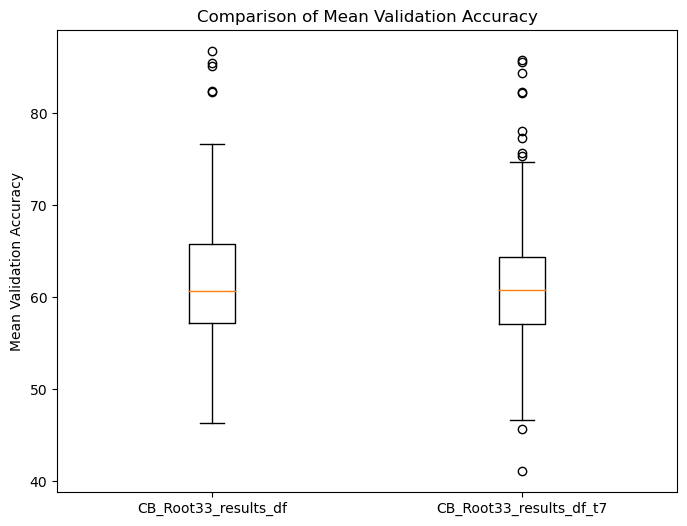

In [18]:
import matplotlib.pyplot as plt

# Assuming that the "Mean Validation Accuracy" columns exist in both dataframes
mean_val_acc_df1 = CB_Root33_results_df["Mean Validation Accuracy"]
mean_val_acc_df2 = CB_Root33_results_df_t7["Mean Validation Accuracy"]

# Create a list of data to plot
data_to_plot = [mean_val_acc_df1, mean_val_acc_df2]

# Create a figure instance
fig, ax = plt.subplots(figsize=(8, 6))

# Create a boxplot
ax.boxplot(data_to_plot, labels=["CB_Root33_results_df", "CB_Root33_results_df_t7"])
ax.set_title("Comparison of Mean Validation Accuracy")
ax.set_ylabel("Mean Validation Accuracy")

# Show the plot
plt.show()

# Novelty predictions

In [9]:
warnings.filterwarnings("ignore")

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
import pandas as pd

def cross_validation(model, _X, _y, _cv=5, x_unseen=None, y_unseen=None):
    '''
    Function to perform 5 Folds Cross-Validation and evaluate accuracy on unseen data.
    
    Parameters
    ----------
    model: Python Class, default=None
            This is the machine learning algorithm to be used for training.
    _X: array
        This is the matrix of features.
    _y: array
        This is the target variable.
    _cv: int, default=5
        Determines the number of folds for cross-validation.
    x_unseen: array, default=None
        Unseen data features for evaluation.
    y_unseen: array, default=None
        Unseen data labels for evaluation.
    
    Returns
    -------
    The function returns a dictionary containing the following metrics for both training set, validation set,
    and the unseen data:
    - 'Training Accuracy scores'
    - 'Mean Training Accuracy'
    - 'Training Precision scores'
    - 'Mean Training Precision'
    - 'Training Recall scores'
    - 'Mean Training Recall'
    - 'Training F1 scores'
    - 'Mean Training F1 Score'
    - 'Validation Accuracy scores'
    - 'Mean Validation Accuracy'
    - 'Std Validation Accuracy'
    - 'Validation Precision scores'
    - 'Mean Validation Precision'
    - 'Validation Recall scores'
    - 'Mean Validation Recall'
    - 'Validation F1 scores'
    - 'Mean Validation F1 Score'
    - 'Mean Unseen Data Accuracy (Threshold 0.5)'
    - 'Mean Unseen Data Accuracy (Threshold 0.7)'
    '''
    _scoring = ['accuracy', 'precision', 'recall', 'f1']
    results = cross_validate(estimator=model,
                            X=_X,
                            y=_y,
                            cv=_cv,
                            scoring=_scoring,
                            return_train_score=True)
    
    train_accuracy = results['train_accuracy'].mean() * 100
    val_accuracy = results['test_accuracy'].mean() * 100

    model.fit(_X,_y)
    
    if x_unseen is not None and y_unseen is not None:
        x_unseen_transformed = preprocessor.transform(x_unseen)
        y_pred_unseen_05 = (model.predict_proba(x_unseen_transformed)[:, 1] > 0.5).astype(int)
        unseen_accuracy_05 = accuracy_score(y_unseen, y_pred_unseen_05) * 100
    else:
        unseen_accuracy_05 = None

    if x_unseen is not None and y_unseen is not None:
        x_unseen_transformed = preprocessor.transform(x_unseen)
        y_pred_unseen_07 = (model.predict_proba(x_unseen_transformed)[:, 1] > 0.7).astype(int)
        unseen_accuracy_07 = accuracy_score(y_unseen, y_pred_unseen_07) * 100
    else:
        unseen_accuracy_07 = None
    
    return {"Training Accuracy scores": results['train_accuracy'],
            "Mean Training Accuracy": train_accuracy,
            "Training Precision scores": results['train_precision'],
            "Mean Training Precision": results['train_precision'].mean(),
            "Training Recall scores": results['train_recall'],
            "Mean Training Recall": results['train_recall'].mean(),
            "Training F1 scores": results['train_f1'],
            "Mean Training F1 Score": results['train_f1'].mean(),
            "Validation Accuracy scores": results['test_accuracy'],
            "Mean Validation Accuracy": val_accuracy,
            "Std Validation Accuracy": results['test_accuracy'].std()*100,
            "Validation Precision scores": results['test_precision'],
            "Mean Validation Precision": results['test_precision'].mean(),
            "Validation Recall scores": results['test_recall'],
            "Mean Validation Recall": results['test_recall'].mean(),
            "Validation F1 scores": results['test_f1'],
            "Mean Validation F1 Score": results['test_f1'].mean(),
            "Mean Unseen Data Accuracy (Threshold 0.5)": unseen_accuracy_05,
            "Mean Unseen Data Accuracy (Threshold 0.7)": unseen_accuracy_07}

CB_Root33_Go_Mean_Accuracy = []
CB_Root33_Go_Std_Accuracy = []
CB_Root33_Go_10cross_Accuracies = []
CB_Root33_Go_10cross_Mean_F1 = []
CB_Root33_Go_10cross_Mean_Precision = []
CB_Root33_Go_10cross_Mean_Recall = []
CB_Root33_results_dict = {}
column_headers = list(Root33_data_setA.columns)

# Define the new threshold (e.g., 0.7)
new_threshold = 0.7

for i in range(len(Feature_columns), Root33_data_setA.shape[1]):
    X = Root33_data_setA.iloc[:, :len(Feature_columns)]
    y = Root33_data_setA.iloc[:, i]

    X_unseen = Root33_data_setA.iloc[:, :len(Feature_columns)]
    y_unseen = Root33_data_setA.iloc[:, i]

    # Determine the minority class
    minority_class = 1 if sum(y == 1) < sum(y == 0) else 0
    minority_indices = np.where(y == minority_class)[0]
    majority_indices = np.where(y != minority_class)[0]
    majority_indices_downsampled = resample(majority_indices, replace=False, n_samples=len(minority_indices), random_state=0)

    print("For this GO Term, Reduced Majority Size:", len(majority_indices_downsampled), "Minority Size:", len(minority_indices))

    # Combine minority and downsampled majority indices
    indices_combined = np.concatenate([minority_indices, majority_indices_downsampled])

    # Subset the data based on the selected indices
    X_balanced = X.iloc[indices_combined, :]
    y_balanced = y.iloc[indices_combined]

    X_unseen_balanced = X_unseen.iloc[indices_combined, :]
    y_unseen_balanced = y_unseen.iloc[indices_combined]

    # Train the random forest model
    goterm = column_headers[i]
    CB_Root33_results_dict[goterm] = cross_validation(pipe, X_balanced, y_balanced, 10, x_unseen=X_unseen_balanced, y_unseen=y_unseen_balanced)

For this GO Term, Reduced Majority Size: 1281 Minority Size: 1281
For this GO Term, Reduced Majority Size: 80 Minority Size: 80
For this GO Term, Reduced Majority Size: 345 Minority Size: 345
For this GO Term, Reduced Majority Size: 83 Minority Size: 83
For this GO Term, Reduced Majority Size: 372 Minority Size: 372
For this GO Term, Reduced Majority Size: 122 Minority Size: 122
For this GO Term, Reduced Majority Size: 140 Minority Size: 140
For this GO Term, Reduced Majority Size: 2244 Minority Size: 2244
For this GO Term, Reduced Majority Size: 344 Minority Size: 344
For this GO Term, Reduced Majority Size: 1066 Minority Size: 1066
For this GO Term, Reduced Majority Size: 63 Minority Size: 63
For this GO Term, Reduced Majority Size: 55 Minority Size: 55
For this GO Term, Reduced Majority Size: 822 Minority Size: 822
For this GO Term, Reduced Majority Size: 539 Minority Size: 539
For this GO Term, Reduced Majority Size: 478 Minority Size: 478
For this GO Term, Reduced Majority Size: 1

In [10]:
CB_Root33_results_df = pd.DataFrame(CB_Root33_results_dict).T
csv_file_path = '28Jan2024_DAPSeq0.7_Root33_results_df.csv'
CB_Root33_results_df.to_csv(csv_file_path, index_label='GO')
CB_Root33_results_df

,Training Accuracy scores,Mean Training Accuracy,Training Precision scores,Mean Training Precision,Training Recall scores,Mean Training Recall,Training F1 scores,Mean Training F1 Score,Validation Accuracy scores,Mean Validation Accuracy,Std Validation Accuracy,Validation Precision scores,Mean Validation Precision,Validation Recall scores,Mean Validation Recall,Validation F1 scores,Mean Validation F1 Score,Mean Unseen Data Accuracy (Threshold 0.5),Mean Unseen Data Accuracy (Threshold 0.7)
GO:0000166,"[0.9622559652928416, 0.9557483731019523, 0.9601040763226366, 0.9631396357328708, 0.9601040763226366, 0.9622723330442324, 0.9575021682567216, 0.9566348655680833, 0.9505637467476149, 0.9592367736339...",95.87562,"[0.9683377308707124, 0.9518486672398968, 0.9674008810572687, 0.978494623655914, 0.9657594381035997, 0.9741992882562278, 0.9655781112091791, 0.9606299212598425, 0.9537117903930131, 0.9600347523892268]",0.9646,"[0.9557291666666666, 0.9601040763226366, 0.9522983521248916, 0.9470945359930616, 0.9540329575021682, 0.9496964440589766, 0.9488291413703382, 0.9522983521248916, 0.9470945359930616, 0.95836947094536]",0.952555,"[0.961992136304063, 0.955958549222798, 0.9597902097902098, 0.9625385632437197, 0.9598603839441535, 0.9617918313570487, 0.9571303587051617, 0.9564459930313589, 0.9503916449086162, 0.959201388888889]",0.95851,"[0.5447470817120622, 0.603112840466926, 0.6171875, 0.55078125, 0.625, 0.609375, 0.55078125, 0.5234375, 0.55859375, 0.62109375]",58.041099,3.619364,"[0.5491803278688525, 0.5955882352941176, 0.5925925925925926, 0.5528455284552846, 0.6159420289855072, 0.6060606060606061, 0.5454545454545454, 0.5182926829268293, 0.5555555555555556, 0.6131386861313...",0.574465,"[0.5193798449612403, 0.6328125, 0.75, 0.53125, 0.6640625, 0.625, 0.609375, 0.6640625, 0.5859375, 0.65625]",0.623813,"[0.5338645418326694, 0.6136363636363635, 0.6620689655172414, 0.5418326693227092, 0.6390977443609022, 0.6153846153846154, 0.5756457564575646, 0.5821917808219178, 0.570342205323194, 0.6339622641509434]",0.596803,73.185012,56.167057
GO:0000287,"[1.0, 1.0, 0.9930555555555556, 1.0, 0.9930555555555556, 1.0, 1.0, 0.9861111111111112, 1.0, 1.0]",99.722222,"[1.0, 1.0, 0.9863013698630136, 1.0, 0.9863013698630136, 1.0, 1.0, 0.9861111111111112, 1.0, 1.0]",0.995871,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9861111111111112, 1.0, 1.0]",0.998611,"[1.0, 1.0, 0.993103448275862, 1.0, 0.993103448275862, 1.0, 1.0, 0.9861111111111112, 1.0, 1.0]",0.997232,"[0.625, 0.5625, 0.625, 0.625, 0.5, 0.75, 0.3125, 0.4375, 0.625, 0.5]",55.625,11.675964,"[0.6, 0.5714285714285714, 0.6, 0.625, 0.5, 0.8333333333333334, 0.3333333333333333, 0.42857142857142855, 0.6666666666666666, 0.5]",0.565833,"[0.75, 0.5, 0.75, 0.625, 0.375, 0.625, 0.375, 0.375, 0.5, 0.625]",0.55,"[0.6666666666666665, 0.5333333333333333, 0.6666666666666665, 0.625, 0.42857142857142855, 0.7142857142857143, 0.35294117647058826, 0.39999999999999997, 0.5714285714285715, 0.5555555555555556]",0.551445,91.25,71.875
GO:0000325,"[0.9887278582930756, 0.9951690821256038, 0.9855072463768116, 0.9855072463768116, 0.9855072463768116, 0.9887278582930756, 0.9951690821256038, 0.9838969404186796, 0.9871175523349437, 0.9871175523349...",98.824477,"[0.9840255591054313, 0.9967637540453075, 0.9870550161812298, 0.9870550161812298, 0.9934426229508196, 0.9840764331210191, 0.9935897435897436, 0.9966996699669967, 0.9967213114754099, 0.9840255591054...",0.990345,"[0.9935483870967742, 0.9935483870967742, 0.9838709677419355, 0.9838709677419355, 0.9774193548387097, 0.9935691318327974, 0.9967845659163987, 0.9710610932475884, 0.977491961414791, 0.9903536977491961]",0.986152,"[0.9887640449438203, 0.9951534733441034, 0.9854604200323102, 0.9854604200323102, 0.9853658536585366, 0.9887999999999999, 0.9951845906902087, 0.9837133550488598, 0.987012987012987, 0.9871794871794871]",0.988209,"[0.7536231884057971, 0.7246376811594203, 0.6521739130434783, 0.6666666666666666, 0.7391304347826086, 0.7101449275362319, 0.6956521739130435, 0.7246376811594203, 0.75362318

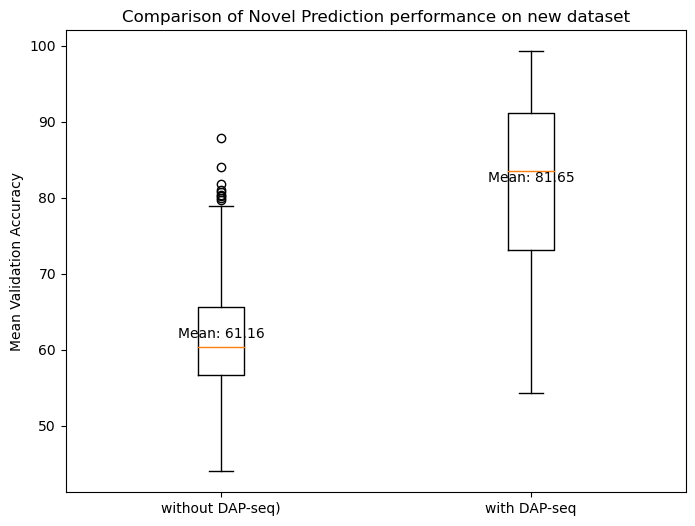

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

root33_df = pd.read_csv('02Feb2023_Root33_results_df.csv')

# Extract the mean validation accuracies
mean_val_acc_df1 = root33_df["Mean Validation Accuracy"]

# Assuming that the "Mean Validation Accuracy" columns exist in both dataframes
mean_val_acc_df2 = CB_Root33_results_df["Mean Unseen Data Accuracy (Threshold 0.5)"]

# Create a list of data to plot
data_to_plot = [mean_val_acc_df1, mean_val_acc_df2]

# Create a figure instance
fig, ax = plt.subplots(figsize=(8, 6))

# Create a boxplot
box = ax.boxplot(data_to_plot, labels=["without DAP-seq)", "with DAP-seq"])

# Calculate and annotate mean values
mean_values = [data.mean() for data in data_to_plot]
for i, mean in enumerate(mean_values):
    ax.text(i + 1, mean, f'Mean: {mean:.2f}', ha='center', va='bottom', fontsize=10)

ax.set_title("Comparison of Novel Prediction performance on new dataset")
ax.set_ylabel("Mean Validation Accuracy")

jpg_path = 'Fig_7_Novel_Predictions_DAPseq.jpg'
plt.savefig(jpg_path, format='jpg', dpi=600)

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load your dataframes
root33_df = pd.read_csv('02Feb2023_Root33_results_df.csv')

# Extract the mean validation accuracies
mean_val_acc_without_dapseq = root33_df["Mean Validation Accuracy"]
mean_val_acc_05 = CB_Root33_results_df["Mean Unseen Data Accuracy (Threshold 0.5)"]
mean_val_acc_07 = CB_Root33_results_df["Mean Unseen Data Accuracy (Threshold 0.7)"]

# Calculate means and standard errors
means = [np.mean(dataset) for dataset in [mean_val_acc_without_dapseq, mean_val_acc_05, mean_val_acc_07]]
std_errors = [np.std(dataset) / np.sqrt(len(dataset)) for dataset in [mean_val_acc_without_dapseq, mean_val_acc_05, mean_val_acc_07]]

# Create a list of data to plot
data_to_plot = [mean_val_acc_without_dapseq, mean_val_acc_05, mean_val_acc_07]

# Create a figure instance
fig, ax = plt.subplots(figsize=(10, 6))

# Create a boxplot
bp = ax.boxplot(data_to_plot, labels=["Without DAP-seq", "With DAP-seq (Threshold 0.5)", "With DAP-seq (Threshold 0.7)"])

# Annotate mean and error
for i in range(len(data_to_plot)):
    ax.text(i+1, max(data_to_plot[i]), f'Mean: {means[i]:.2f}', ha='center', va='bottom', fontsize=10)

ax.set_title("Comparison of Novel Predictions Across Different Conditions")
ax.set_ylabel("Mean Validation Accuracy")


jpg_path = 'Fig_7_Novel_DAPseq.jpg'
plt.savefig(jpg_path, format='jpg', dpi=600)

# Show the plot
plt.show()

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load your dataframes
root33_df = pd.read_csv('02Feb2023_Root33_results_df.csv')

# Extract the mean validation accuracies
mean_val_acc_without_dapseq = root33_df["Mean Validation Accuracy"]
mean_val_acc_05 = root33_df["Mean Unseen Data Accuracy (Threshold 0.5)"]

# Calculate means and standard errors
means = [np.mean(mean_val_acc_without_dapseq), np.mean(mean_val_acc_05)]
std_errors = [np.std(mean_val_acc_without_dapseq) / np.sqrt(len(mean_val_acc_without_dapseq)), np.std(mean_val_acc_05) / np.sqrt(len(mean_val_acc_05))]

# Create a list of data to plot
data_to_plot = [mean_val_acc_without_dapseq, mean_val_acc_05]

# Create a figure instance
fig, ax = plt.subplots(figsize=(8, 6))

# Create a boxplot
bp = ax.boxplot(data_to_plot, labels=["Without DAP-seq", "With DAP-seq (Threshold 0.5)"])

# Annotate mean and error
for i in range(len(data_to_plot)):
    ax.text(i+1, max(data_to_plot[i]), f'Mean: {means[i]:.2f}', ha='center', va='bottom', fontsize=10)

ax.set_title("Comparison of Validation Accuracy")
ax.set_ylabel("Mean Validation Accuracy")

jpg_path = 'Fig_7_Comparison.jpg'
plt.savefig(jpg_path, format='jpg', dpi=600)

# Show the plot
plt.show()


KeyError: 'Mean Unseen Data Accuracy (Threshold 0.5)'

Wilcoxon statistic: 0.0
P-value: 5.405572410884125e-39


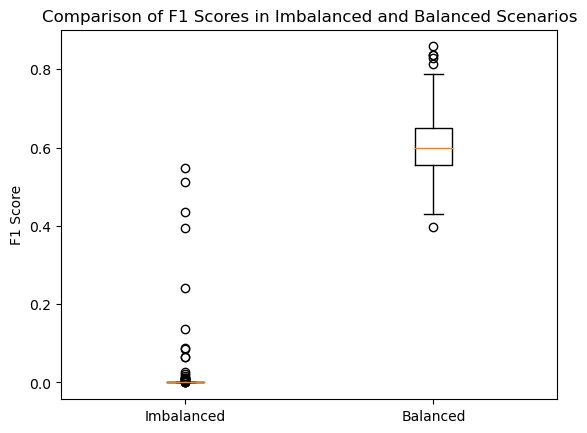

In [57]:
import numpy as np
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt

imbalanced_data = Root33_results_df["Mean Validation F1 Score"].tolist()
balanced_data = pd.DataFrame(CB_Root33_results_dict).T["Mean Validation F1 Score"].tolist()

# Perform Wilcoxon signed-rank test
statistic, p_value = wilcoxon(imbalanced_data, balanced_data)

# Display the results
print(f"Wilcoxon statistic: {statistic}")
print(f"P-value: {p_value}")

# Visualize the results with a box plot
plt.boxplot([imbalanced_data, balanced_data], labels=['Imbalanced', 'Balanced'])
plt.title('Comparison of F1 Scores in Imbalanced and Balanced Scenarios')
plt.ylabel('F1 Score')
plt.show()

Wilcoxon statistic: 0.0
P-value: 5.405572410884125e-39


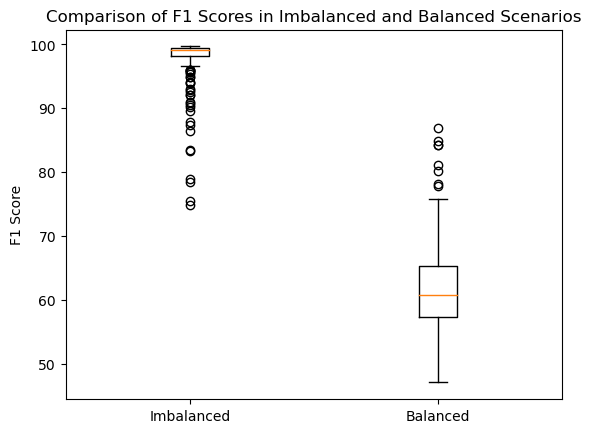

In [58]:
import numpy as np
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt

imbalanced_data = Root33_results_df["Mean Validation Accuracy"].tolist()
balanced_data = pd.DataFrame(CB_Root33_results_dict).T["Mean Validation Accuracy"].tolist()

# Perform Wilcoxon signed-rank test
statistic, p_value = wilcoxon(imbalanced_data, balanced_data)

# Display the results
print(f"Wilcoxon statistic: {statistic}")
print(f"P-value: {p_value}")

# Visualize the results with a box plot
plt.boxplot([imbalanced_data, balanced_data], labels=['Imbalanced', 'Balanced'])
plt.title('Comparison of F1 Scores in Imbalanced and Balanced Scenarios')
plt.ylabel('F1 Score')
plt.show()